In [1]:
import operator
import collections
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from collections import Counter
pd.set_option('display.float_format', lambda x: '%.3f' % x)

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

In [2]:
data = pd.read_csv('../Data/bid_notick.txt', sep="|")
data = data.drop(labels='Unnamed: 11', axis=1)
features = [column for column in data.columns]
corr = data.corr(method='pearson')
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
listing_labels = sorted(data.groupby('ListingStatus').groups.keys())
bid_labels = sorted(data.groupby('Status').groups.keys())
n = len(data)

In [3]:
print ("Dataset dimension: {0}".format(data.shape))
print ("Dataset contains {0} records.".format(n))
print ("Dataset contains {0} features: {1}.".format(len(features), features))

Dataset dimension: (9732656, 11)
Dataset contains 9732656 records.
Dataset contains 11 features: ['Amount', 'CreationDate', 'Bid_Key', 'ListingKey', 'ListingStatus', 'MemberKey', 'MinimumRate', 'MinimumYield', 'ParticipationAmount', 'Status', 'ModifiedDate'].


## Bid Object Description

<table border="0" cellspacing="0" cellpadding="4" style="font-family:Verdana;font-size:11px">
<tbody><tr style="background-color:#E3E1CA">
<th>Name</th>
<th>Label</th>
<th>Type</th>
<th>Description</th>
</tr>
<tr>
<td><b>Amount</b></td>
<td>Amount</td>
<td>decimal</td>
<td>The amount that was bid.</td>
</tr>
<tr style="background-color:#F4F4E8">
<td><b>CreationDate</b></td>
<td>Creation Date</td>
<td>datetime</td>
<td>The date the bid was created.</td>
</tr>
<tr>
<td><b>Key</b></td>
<td>Key</td>
<td>string</td>
<td>The primary key identifier for the Bid Object. All Bids have a unique Key.</td>
</tr>
<tr style="background-color:#F4F4E8">
<td><b>ListingKey</b></td>
<td>Listing Key</td>
<td>string</td>
<td>The Key of the Listing the Bid was placed on. See the Listing Object for more information.</td>
</tr>
<tr>
<td><b>ListingStatus</b></td>
<td>Listing Status</td>
<td>string</td>
<td>
The status of the Listing is one of the following values:<br>
<b>Active</b> - The listing is current active in the marketplace<br>
<b>Withdrawn</b> - The listing was withdrawn by customer request<br>
<b>Expired</b> - The listing failed to fund in time<br>
<b>Completed</b> - The listing ran to completion and funded<br>
<b>Cancelled</b> - The listing was canceled by Prosper<br>
<b>Pending Verification</b> - The listing ran to completion but is awaiting additional bank or identity verification<br>
</td>
</tr>
<tr style="background-color:#F4F4E8">
<td><b>MemberKey</b></td>
<td>Member Key</td>
<td>string</td>
<td>The Key of the Member who placed this bid. See the Member Object for more information.</td>
</tr>
<tr>
<td><b>MinimumRate</b></td>
<td>Minimum Rate</td>
<td>decimal</td>
<td>This is the minimum rate that the Lender is willing to accept on their bid. This field is populated only if the bid Status is Outbid, otherwise it is Null. (As is currently exposed on the website).</td>
</tr>
<tr style="background-color:#F4F4E8">
<td><b>ParticipationAmount</b></td>
<td>Participation Amount</td>
<td>decimal</td>
<td>The amount of the Bid Amount that is winning and therefore participating in the bid.</td>
</tr>
<tr>
<td><b>Status</b></td>
<td>Status</td>
<td>string</td>
<td>
The status of the Bid is one of the following values:<br>
<b>Winning</b><br>
<b>Partially Participating</b><br>
<b>Outbid</b><br>
<b>Bid Withdrawn</b><br>
</td>
</tr>
</tbody></table>

## Compute Lender Age

In [4]:
data = data[data.ListingStatus=="Completed"]
data = data[["ListingKey", "CreationDate", "MemberKey"]]
data.head()

,ListingKey,CreationDate,MemberKey
0,D6473365888221963456102,2006-02-21 20:23:20,F4273365023760472DBD934
1,D6473365888221963456102,2006-02-21 22:50:00,F4273365023760472DBD934
3,601833660859080305A2AC3,2006-02-28 20:06:43,F4273365023760472DBD934
4,601833660859080305A2AC3,2006-03-01 09:27:50,F4273365023760472DBD934
5,73AB3364393429683903176,2006-02-23 17:06:04,F4273365023760472DBD934


In [5]:
member_data = pd.read_csv('../Data/member.txt', sep="|", converters={'FriendMemberKeys': lambda x: x[1:-1].split(','),
                                                                     'Roles': lambda x: x[1:-1].split(',')})
member_data = member_data[["Mem_Key", "CreationDate"]]
member_data = member_data.rename(index=str, columns={"Mem_Key": "MemberKey", "CreationDate": "MemberCreationDate"})
member_data.head()

c:\python27\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,MemberKey,MemberCreationDate
0,19F03365539649838297324,2005-10-31 00:16:00
1,69FF3364999125356EF09CB,2005-10-31 00:16:00
2,F4273365023760472DBD934,2005-10-31 00:17:00
3,754933652214816673645F0,2005-10-31 00:18:00
4,7BFA33650989773378C52A6,2005-10-31 00:19:00


In [6]:
final_data = data.merge(member_data, on="MemberKey", how="left")
final_data.head()

,ListingKey,CreationDate,MemberKey,MemberCreationDate
0,D6473365888221963456102,2006-02-21 20:23:20,F4273365023760472DBD934,2005-10-31 00:17:00
1,D6473365888221963456102,2006-02-21 22:50:00,F4273365023760472DBD934,2005-10-31 00:17:00
2,601833660859080305A2AC3,2006-02-28 20:06:43,F4273365023760472DBD934,2005-10-31 00:17:00
3,601833660859080305A2AC3,2006-03-01 09:27:50,F4273365023760472DBD934,2005-10-31 00:17:00
4,73AB3364393429683903176,2006-02-23 17:06:04,F4273365023760472DBD934,2005-10-31 00:17:00


In [7]:
final_data["LenderAge"] = (pd.to_datetime(final_data.CreationDate) - pd.to_datetime(final_data.MemberCreationDate)).dt.days
final_data.head()

,ListingKey,CreationDate,MemberKey,MemberCreationDate,LenderAge
0,D6473365888221963456102,2006-02-21 20:23:20,F4273365023760472DBD934,2005-10-31 00:17:00,113.000
1,D6473365888221963456102,2006-02-21 22:50:00,F4273365023760472DBD934,2005-10-31 00:17:00,113.000
2,601833660859080305A2AC3,2006-02-28 20:06:43,F4273365023760472DBD934,2005-10-31 00:17:00,120.000
3,601833660859080305A2AC3,2006-03-01 09:27:50,F4273365023760472DBD934,2005-10-31 00:17:00,121.000
4,73AB3364393429683903176,2006-02-23 17:06:04,F4273365023760472DBD934,2005-10-31 00:17:00,115.000


In [8]:
final_data[["ListingKey", "MemberKey", "LenderAge"]].to_csv("../Data/lender_age_raw.csv", index=False)

In [37]:
f_avg = {'ListingKey': ['max'],
         'LenderAge': ['median']}
# lender_age_data = 
final_data["Lst_Key"] = final_data.ListingKey
lender_age_data = pd.DataFrame(final_data[["Lst_Key", "ListingKey", "LenderAge"]].groupby(["Lst_Key"]).agg(f_avg).as_matrix())
lender_age_data = lender_age_data.rename(index=str, columns={0: "LenderMedianAge", 
                                                             1: "ListingKey"})
lender_age_data.head()

c:\python27\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


,LenderMedianAge,ListingKey
0,256.000,00033425227988088FA6752
1,1292.500,000335337029714661FD4AD
2,57.500,000433785890431972B4743
3,264.000,0005353671687550573289D
4,152.000,00083422661625108817246


In [38]:
lender_age_data.to_csv("../Data/lender_age.csv", index=False)

## Summary Statistics

In [5]:
data.describe()

,Amount,MinimumRate,MinimumYield,ParticipationAmount
count,9732656.000,2814036.000,2814036.000,9732656.000
mean,79.570,0.171,0.163,54.730
std,241.330,0.062,0.062,222.067
min,-50.100,0.000,-0.005,0.000
25%,45.000,0.124,0.116,0.000
50%,50.000,0.160,0.150,36.000
75%,74.430,0.208,0.199,50.000
max,25000.000,0.500,0.495,25000.000


## Correlation Matrix

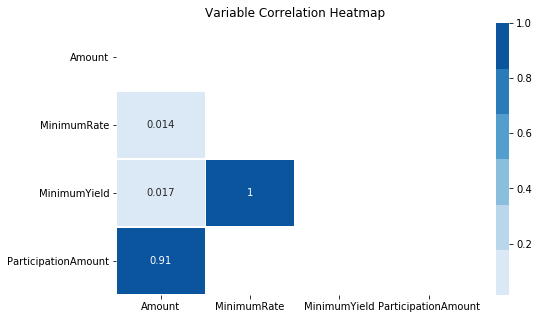

In [6]:
plt.figure(figsize=(8,5))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.color_palette("Blues"),
        mask = mask,
        linewidths=.5,
        annot=True)
plt.title("Variable Correlation Heatmap")
plt.show()

## Listing Status

ListingStatus
Active                  18953
Cancelled             1332169
Completed             6301000
Expired               1297213
Pending Completion      10986
Withdrawn              772335
dtype: int64


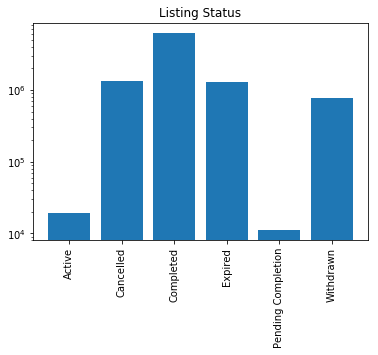

In [7]:
print data.groupby('ListingStatus').size()
plt.bar(listing_labels, 
        data.groupby('ListingStatus').size())
plt.yscale('log')
plt.xticks(range(6), listing_labels, rotation='vertical')
plt.title('Listing Status')
plt.show()

## Bid Status

Status
Bid Withdrawn                   79
Outbid                     2813957
Partially Participating      46516
Winning                    6872104
dtype: int64


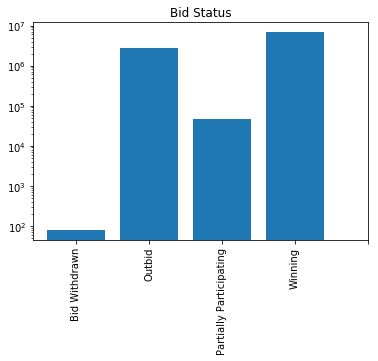

In [8]:
print data.groupby('Status').size()
plt.bar(bid_labels, 
        data.groupby('Status').size())
plt.yscale('log')
plt.xticks(range(5), bid_labels, rotation='vertical')
plt.title('Bid Status')
plt.show()

## Network Analysis

In [9]:
try:  # Python 3.x
    import urllib.request as urllib
except ImportError:  # Python 2.x
    import urllib
import io
import zipfile

import matplotlib.pyplot as plt
import networkx as nx

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read('football.txt').decode()  # read info file
gml = zf.read('football.gml').decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split('\n')[1:]
G = nx.parse_gml(gml)  # parse gml data

G_ud = G.to_undirected() # Convert graph to undirected
# print(txt)
# # print degree for each team - number of games
# for n, d in G.degree():
#     print('%s %d' % (n, d))

options = {
    'node_color': 'black',
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
}

# G=nx.from_pandas_edgelist(data,'Bid_Key', 'ListingKey', create_using=nx.DiGraph())
# G = nx.gn_graph(100, kernel=lambda x: x ** 2.0)


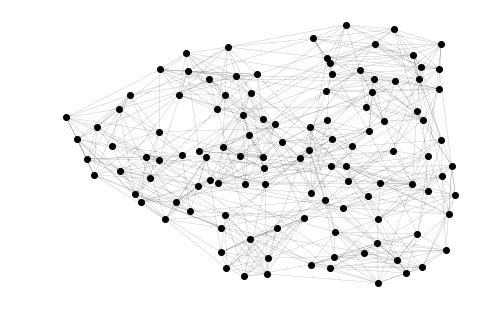

In [10]:
nx.draw(G, **options)

## Graph Properties

In [11]:
N,K = G.order(), G.size()
avg_deg = float(K)/N

print "Nodes: ", N
print "Edges: ", K
print "Average degree: ", avg_deg

degree_sequence = sorted([d for n, d in G_ud.degree()], reverse=True)
print "Degree sequence", degree_sequence
dmax = max(degree_sequence)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

try:
    in_degrees = G.in_degree() # dictionary node:degree
    in_values = sorted(set(dict(in_degrees).values()))
    in_hist = [dict(in_degrees).values().count(x) for x in in_values]
except Exception, e:
    in_values = None
    print e

try:
    out_degrees = G.out_degree() # dictionary node:degree
    out_values = sorted(set(dict(out_degrees).values()))
    out_hist = [dict(out_degrees).values().count(x) for x in out_values]
except Exception, e:
    print e

Nodes:  115
Edges:  613
Average degree:  5.33043478261
Degree sequence [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 8, 8, 8, 7]
'Graph' object has no attribute 'in_degree'
'Graph' object has no attribute 'out_degree'


## Degree Distribution

In [12]:
if in_values:
    plt.figure()
    plt.plot(in_values,in_hist,'ro-') # in-degree
    plt.plot(out_values,out_hist,'bv-') # out-degree
    plt.legend(['In-degree','Out-degree'])
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.title('Listing-Bid network')
    plt.show()
else:
    pass

## Degree Histogram

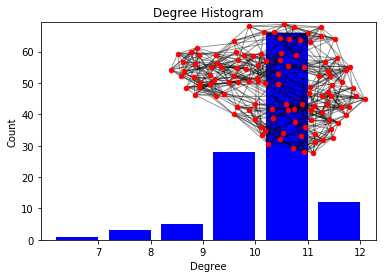

In [13]:
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G_ud), key=len, reverse=True)[0]
pos = nx.spring_layout(G_ud)
plt.axis('off')
nx.draw_networkx_nodes(G_ud, pos, node_size=20)
nx.draw_networkx_edges(G_ud, pos, alpha=0.4)

plt.show()

## Degree Rank

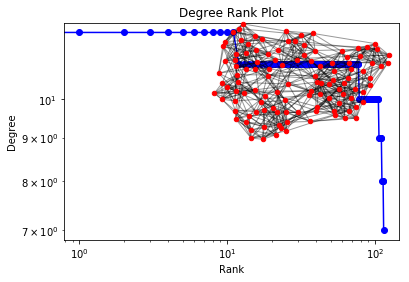

In [14]:
plt.loglog(degree_sequence, 'b-', marker='o')
plt.title("Degree Rank Plot")
plt.ylabel("Degree")
plt.xlabel("Rank")

# draw graph in inset
plt.axes([0.45, 0.45, 0.45, 0.45])
Gcc = sorted(nx.connected_component_subgraphs(G_ud), key=len, reverse=True)[0]
pos = nx.spring_layout(Gcc)
plt.axis('off')
nx.draw_networkx_nodes(Gcc, pos, node_size=20)
nx.draw_networkx_edges(Gcc, pos, alpha=0.4)

plt.show()

## Clustering Coefficient

In [15]:
# Clustering coefficient of all nodes (in a dictionary)
clust_coefficients = nx.clustering(G_ud)
# Average clustering coefficient
ccs = nx.clustering(G_ud)
avg_clust = sum(ccs.values()) / len(ccs)
print "Average clustering coefficient: ", avg_clust

Average clustering coefficient:  0.403216011042
